In [1]:
import numpy as np
import pandas as pd
import os
from scipy.integrate import quad_vec
import matplotlib.pyplot as plt
sndata = pd.read_csv('./Data/parsonage.txt', sep = ' ', engine='python')


# 1. Setting priors

\# Omega_radiation calculation

$$\epsilon_{rad,0} = \cfrac{4}{c}\sigma T^4 \approx 2.5\times 10^{-15} \mathrm{J/m^3}$$
$$\epsilon_{crit,0} = \cfrac{3c^2H_0^2}{8\pi G} = \cfrac{3c^2h^2(100\mathrm{km/s/Mpc})^2}{8\pi G}\approx 1.7\times 10^{-9}h^2 \mathrm{J/m^3} $$ 
$$\Omega_{rad,0} = \cfrac{\epsilon_{rad,0}}{\epsilon_{crit,0}} \approx 1.48\times 10^{-6}h^{-2}$$

We can ignore the energy density of radiation since it's small.

The Age of the universe would be come into account for developing prior.

$$t_{Age} >= 15 \text{Gyr}$$

There will be two models to be considered as a candidate for the Universe.

1. Flat LCDM
2. Curved LCDM

In [33]:
import astropy.units as u

# Unit conversion of the Hubble constant from km/s/Mpc to Gyr^-1
result = (1 * u.km / u.s/u.Mpc)
result2 = result.to(1/u.Gyr)
print(result2)
from astropy.constants import c, G

# Define H0 in terms of h (dimensionless Hubble constant)
# H0 = 100 * h km/s/Mpc
# We want the result in units of h^2 J/m^3, so we calculate the part without h^2 first.
H100 = 100 * u.km / u.s / u.Mpc

# Critical energy density formula: 3 * c^2 * H0^2 / (8 * pi * G)
# We calculate epsilon_crit / h^2
epsilon_crit_div_h2 = (3 * c**2 * H100**2 / (8 * np.pi * G))

# Convert to J/m^3
epsilon_crit_div_h2_J_per_m3 = epsilon_crit_div_h2.to(u.J / u.m**3)
erad = 2.5*10**-15 * u.J/u.m**3
Omega_rad = erad / epsilon_crit_div_h2_J_per_m3
print(f"Critical energy density = {epsilon_crit_div_h2_J_per_m3} h^2")
print(f"Omega_rad = {Omega_rad}")

0.0010227121650456948 1 / Gyr
Critical energy density = 1.6881692556555721e-09 J / m3 h^2
Omega_rad = 1.4808941648621407e-06


In [27]:

# Get the Hubble constant from Planck 2018 cosmology (km/s/Mpc)

# Convert 1/H0 to gigayears

def integrand(a, omegam, omegalamb):
    omega0 = omegam + omegalamb
    y2 = omegam/a + omegalamb*a**2 + (1-omega0)
    y = np.sqrt(y2)
    return 1/y
def AgeofUniverse(H0,omegam, omegalamb):
    I = quad_vec(integrand,0,1, args=(omegam, omegalamb))
    H0_Gyr = H0 * 0.0010227121650456948 # Hubble constant in Gyr^-1
    H0_inverse = 1/H0_Gyr # Hubble constant in Gyr^-1
    T = I[0]*H0_inverse # age is in Gyr, 1/H_0 ~ 14.452 Gyr
    return T

## 1-1. Flat LCDM Prior

In [102]:
# Calculate the prior for Flat LCDM
omegam = np.linspace(0.0, 1., 200)
omegalamb = 1.0 - omegam
Hubble0 = np.linspace(0.01,100,300)
H_Flat, M_Flat = np.meshgrid(Hubble0, omegam)
L_Flat = 1 - M_Flat
prior_flat = np.zeros(M_Flat.shape)
age_flat = AgeofUniverse(H_Flat, M_Flat, L_Flat)
prior_flat[age_flat >= 15] = 1
np.save('prior_flat.npy', prior_flat)

/var/folders/h8/5hxv73fd07d033x49543ghl00000gn/T/ipykernel_10537/4214976936.py:9: RuntimeWarning: divide by zero encountered in divide
  return 1/y
/opt/anaconda3/lib/python3.12/site-packages/scipy/integrate/_quad_vec.py:521: RuntimeWarning: invalid value encountered in subtract
  s_k_dabs += v[i] * abs(fv[i] - y0)


In [5]:
prior_flat = np.load('prior_flat.npy')
omegam = np.linspace(0.0, 1, 200)
omegalamb = 1.0 - omegam
Hubble0 = np.linspace(0.01,100,300)
H_Flat, M_Flat = np.meshgrid(Hubble0, omegam)


In [3]:
Hubble0[1] - Hubble0[0]  # Difference between first two Hubble constants

0.3344147157190635

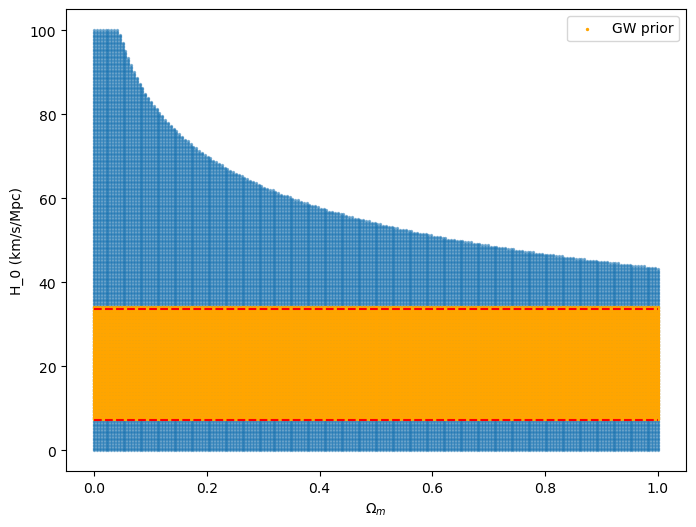

In [25]:

# Hubble0와 omegam은 prior_flat의 축과 일치해야 합니다.
# prior_flat이 1인 위치의 인덱스를 찾음
idx = np.where(prior_flat == 1)
max_h = 20.52832336 + 5*2.64373053
min_h = 20.52832336 - 5*2.64373053

cond1 = np.where((H_Flat >= min_h) & (H_Flat <= max_h+0.4) & (prior_flat == 1))

# x축: omegam, y축: Hubble0
plt.figure(figsize=(8, 6))
plt.scatter(M_Flat[idx], H_Flat[idx], s=2, alpha=0.5, zorder = 1)
plt.scatter(M_Flat[cond1], H_Flat[cond1], s=2, alpha=1, color='orange',label = 'GW prior', zorder = 2)
plt.hlines(y = min_h, xmin=0, xmax=1, color='red', linestyle='--', zorder=3)
plt.hlines(y = max_h, xmin=0, xmax=1, color='red', linestyle='--', zorder=3)
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'H_0 (km/s/Mpc)')
plt.legend()
plt.savefig('./Figs/prior_flat.png', dpi=300, bbox_inches='tight')
plt.show()

Prior_flat1 : 0< Hubble constant < 43.13443443, 0 < Omega_m < 1

Prior_flat2 : 43.13443443 < Hubble constant < 69.15525525525524, 0 < Omega_m < 0.20841683366733466

Prior_flat3 : 69.15525525525524 < Hubble constant < 81.66526526526525, 0 < Omega_m < 0.10821643286573146

## 1-2. Curved LCDM prior

In [84]:
from scipy.optimize import fsolve

omegam = np.linspace(0.0, 20, 100)
omegalamb = np.linspace(-3, 3, 100)

def integrand(z, parm):
    Ez2 = (parm[0] * (1+z)**3 + parm[1] + (1-parm[0]-parm[1]) * (1+z)**2)
    if Ez2 <= 0:
        Ez = np.sqrt(-Ez2)
    else:
        Ez = np.sqrt(Ez2)
    return Ez2

def solve_for_parm(p1, p2):
    parm = [p1, p2]
    try:
        sol = fsolve(integrand, sndata['zcmb'].max(), args=(parm,))
        return sol[0]
    except:
        return np.nan

# vectorize로 함수를 배열 처리 가능하게 만들기
solve_vectorized = np.vectorize(solve_for_parm)

M,L = np.meshgrid(omegam, omegalamb)
results = solve_vectorized(M,L)

/var/folders/h8/5hxv73fd07d033x49543ghl00000gn/T/ipykernel_10537/2226932826.py:17: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(integrand, sndata['zcmb'].max(), args=(parm,))
/var/folders/h8/5hxv73fd07d033x49543ghl00000gn/T/ipykernel_10537/2226932826.py:17: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  sol = fsolve(integrand, sndata['zcmb'].max(), args=(parm,))


In [85]:
resultind = np.zeros_like(results)
resultind[np.isnan(results) | (results >0)] = 1

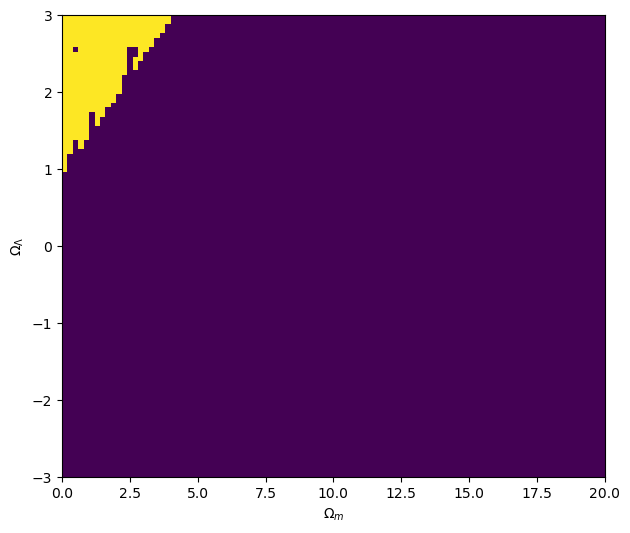

In [86]:
plt.figure(figsize=(7, 6))
plt.imshow(resultind, cmap='viridis', aspect='auto', origin='lower',
           extent=[omegam[0], omegam[-1], omegalamb[0], omegalamb[-1]])
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\Omega_\Lambda$')
plt.xlim(0, 20)
#plt.ylim(-10, 10)
plt.savefig('./Figs/2D_prior.png', dpi=300)
plt.show()
# Omegam = [0,20], Omegalam = [-3,1]까지가 첫번째 prior!

In [17]:
# Calculate the prior for Curved LCDM
omegam = np.linspace(0.0, 10., 200)
omegalamb = np.linspace(-3., 1., 100)
Hubble0 = np.linspace(15.,80., 200)
H, M, L = np.meshgrid(Hubble0, omegam, omegalamb)
prior_curved = np.zeros(M.shape)
age = AgeofUniverse(H, M, L)
prior_curved[age >= 15] = 1
np.save('prior_curved.npy', prior_curved)

/var/folders/h8/5hxv73fd07d033x49543ghl00000gn/T/ipykernel_26877/4214976936.py:9: RuntimeWarning: divide by zero encountered in divide
  return 1/y
/opt/anaconda3/lib/python3.12/site-packages/scipy/integrate/_quad_vec.py:521: RuntimeWarning: invalid value encountered in subtract
  s_k_dabs += v[i] * abs(fv[i] - y0)


In [18]:
omegam = np.linspace(0.0, 10., 200)
omegalamb = np.linspace(-3., 1., 100)
Hubble0 = np.linspace(15.,80., 200)
H, M, L = np.meshgrid(Hubble0, omegam, omegalamb)
prior_curved = np.load('prior_curved.npy')

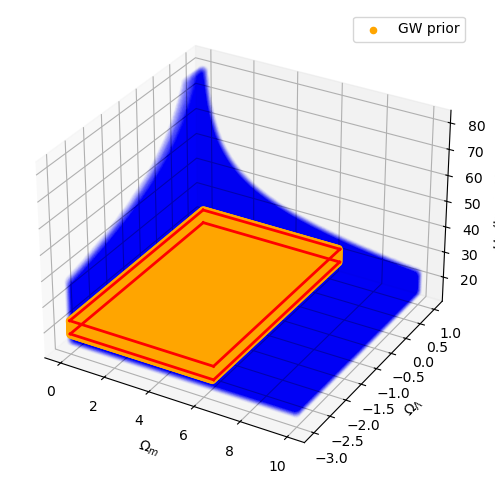

In [19]:
# ...existing code...
idx = np.where(prior_curved == 1)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)

# 파란 점(전체 prior)을 먼저 plot (맨 뒤로)
blue = ax.scatter(M[idx], L[idx], H[idx], c='b', marker='o', alpha=0.01, zorder=1)
max_h = 20.52832336 + 1*2.64373053
min_h = 20.52832336 - 1*2.64373053
cond11 = np.where((H >=max_h) & (H < max_h + 0.4) & (prior_curved == 1) & (L == -3))
cond12 = np.where((H >=min_h) & (H < min_h + 0.4) & (prior_curved == 1) & (L == 1))
x_max = M[cond11][-1]

y_line = [-3,1]
z_max = H[cond11][-1]
z_min = H[cond12][-1]
ax.plot([x_max, x_max], y_line, [z_max, z_max], color='red', lw=2, zorder=3)
ax.plot([0,x_max], [-3, -3], [z_max, z_max], color='red', lw=2, zorder=3)
ax.plot([0,0], [-3, 1], [z_max, z_max], color='red', lw=2, zorder=3)
ax.plot([0,x_max], [1,1], [z_max, z_max], color='red', lw=2, zorder=3)

ax.plot([x_max, x_max], y_line, [z_min, z_min], color='red', lw=2, zorder=3)
ax.plot([0,x_max], [-3, -3], [z_min, z_min], color='red', lw=2, zorder=3)
ax.plot([0,0], [-3, 1], [z_min, z_min], color='red', lw=2, zorder=3)
ax.plot([0,x_max], [1,1], [z_min, z_min], color='red', lw=2, zorder=3)

condgw = np.where((H >= min_h) & (H < max_h + 0.4) & (prior_curved == 1) & (M < x_max))
ax.scatter(M[condgw], L[condgw], H[condgw], c='orange', marker='o', alpha=1, zorder=2, label='GW prior')

ax.set_xlabel(r'$\Omega_m$')
ax.set_ylabel(r'$\Omega_\Lambda$')
ax.set_zlabel(r'$H_0$ (km/s/Mpc)')
plt.savefig('./Figs/curved_prior.png',bbox_inches = 'tight', dpi=300)
plt.legend()
plt.show()

In [24]:
20.52832336 + 5*2.64373053

33.74697601

## 1-3 Prior from GW data

We will use GW data, which is relatively in small redshifts, to get a rough estimate of the prior.

To do so, we will use an approximate relaltion for the current proper distance & calculate luminosity distance with it.

$$ d_p(t_0) \approx \cfrac{cz}{H_0}$$

In [ ]:
# GW data
z_GW = np.array([0.0101,0.0067])
dl_GW = np.array([150.9, 95.4]) # Mpc
ddl_GW = np.array([14,14.5])

In [ ]:
def propdist_approx(z,H0):
    # Approximate the luminosity distance for small redshifts
    c = 299792.458  # speed of light in km/s
    dp = c*z/H0
    dl = (1+z)*dp
    return dl

In [ ]:
from scipy.optimize import curve_fit

gwpopt, gwpcov = curve_fit(propdist_approx, z_GW, dl_GW, sigma=ddl_GW, absolute_sigma=True)
print("Flat LCDM fit parameters (H0, omegam):", gwpopt)
print("Flat LCDM fit covariance matrix:\n", gwpcov)

Flat LCDM fit parameters (H0, omegam): [20.52832336]
Flat LCDM fit covariance matrix:
 [[2.64373053]]


In [20]:
20.52832336 + 1*2.64373053, 20.52832336 - 1*2.64373053

(23.17205389, 17.884592830000003)

Prior_final : 4.66594018 < H0 < 36.39070654 $$({H0_{avg}} \pm 6\sigma_{H0})$$

In [28]:
AgeofUniverse(20.52832336 + 1*2.64373053, 6.4, -3)

15.236286970330756

In [29]:
from astropy.cosmology import LambdaCDM
from astropy import units as u
# Curved LCDM 모델 파라미터 설정
H0_curved =  20.52832336 + 1*2.64373053 # Hubble constant in km/s/Mpc
Om0_curved = 6.4  # Omega_m at z=0
Ode0_curved = -3  # Omega_lambda (dark energy) at z=0
# Omega_k는 1 - Om0_curved - Ode0_curved 로 자동 계산됨 (이 경우 0.1)

# LambdaCDM 객체 생성
cosmo_curved = LambdaCDM(H0=H0_curved * u.km / u.s / u.Mpc, Om0=Om0_curved, Ode0=Ode0_curved)

# 우주의 나이 계산
age_curved = cosmo_curved.age(0)